## Preliminaries

To plot the results presented in the paper, you will need to download the dataframes first from [this link](https://titan.gml-team.ru:5003/sharing/x6XwCssiA) (.zip file, 271MB). Unzip it as `./data` directory.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
codecs = []
with open('codecs.txt', 'r') as f:
    for line in f:
        codecs.append(line.strip())
attacks = []
with open('methods.txt', 'r') as f:
    for line in f:
        attacks.append(line.strip())
codecs = [d for d in codecs if d != '']
base_codecs = list(set(['-'.join(x.split('-')[:-1]) for x in codecs]))
base_codecs_compressai = ['bmshj2018-hyperprior-vbr', 'bmshj2018-factorized', 'cheng2020-anchor', 'cheng2020-attn', 'evc','mbt2018-mean', 'mbt2018']
jpegai_codecs = ['jpegai-v61-hop', 'jpegai-v61-bop', 'jpegai-v51-hop', 'jpegai-v51-bop', 'jpegai-v41-hop', 'jpegai-v41-bop', 'jpegai-v71-hop', 'jpegai-v71-bop']

codec_variants = {}
for c in base_codecs:
    codec_variants[c] = list(set([x.split('-')[-1] for x in codecs if x.startswith(c)]))
    if c in base_codecs_compressai:
        codec_variants[c].sort()
    elif c in jpegai_codecs:
        codec_variants[c] = ['b0002', 'b0012', 'b0075', 'b05']
        if 'v41' in c:
           codec_variants[c] = ['b0002', 'b0007', 'b0015', 'b005'] 
    elif c != 'cdc-xparam':
        codec_variants[c].sort(key=lambda x: int(x))
    elif c == 'cdc-xparam':
        codec_variants[c].sort(key=lambda x: int(x[1:]))
codec_variants

{'hific': ['014', '030', '045'],
 'jpegai-v61-bop': ['b0002', 'b0012', 'b0075', 'b05'],
 'jpegai-v41-bop': ['b0002', 'b0007', 'b0015', 'b005'],
 'evc': ['1', '2', '4', '6'],
 'bmshj2018-hyperprior': ['1', '2', '4', '6'],
 'cheng2020-anchor': ['1', '2', '4', '6'],
 'mbt2018': ['1', '2', '4', '6'],
 'elic': ['0004', '0016', '0450'],
 'qres-vae': ['16', '256', '2048'],
 'cdc-xparam': ['b00032', 'b01024', 'b02048'],
 'mbt2018-mean': ['1', '2', '4', '6'],
 'jpegai-v41-hop': ['b0002', 'b0007', 'b0015', 'b005'],
 'jpegai-v61-hop': ['b0002', 'b0012', 'b0075', 'b05'],
 'jpegai-v71-hop': ['b0002', 'b0012', 'b0075', 'b05'],
 'jpegai-v71-bop': ['b0002', 'b0012', 'b0075', 'b05'],
 'lic-tcm': ['005', '0013', '00025'],
 'cheng2020-attn': ['1', '2', '4', '6'],
 'bmshj2018-hyperprior-vbr': ['1', '2', '4', '6'],
 'jpegai-v51-hop': ['b0002', 'b0012', 'b0075', 'b05'],
 'bmshj2018-factorized': ['1', '2', '4', '6'],
 'jpegai-v51-bop': ['b0002', 'b0012', 'b0075', 'b05']}

In [18]:
better_loss_names = {
    'added_noises_loss':'Added Noises (YCbCr)',
    'added_noises_loss_Y':'Added Noises (Y)',
    'ftda_default_loss':'FTDA Loss (YCbCr)',
    'ftda_default_loss_Y':'FTDA Loss (Y)',
    'bpp_increase_loss':'Increase BPP (YCbCr)',
    'reconstr_loss':'Reconstruction Loss (YCbCr, $L_2$)',
    'reconstr_loss_Y':'Reconstruction Loss (Y, $L_2$)',
    'reconstruction_msssim_loss':'Reconstruction Loss (YCbCr, MS-SSIM)',
    'ftda_msssim_loss':'FTDA Loss (YCbCr, MS-SSIM)',
    'src_reconstr_loss_Y':'Source Reconstruction (Y, $L_2$)'
}
defense_2_name = {
    'diffpure':'DiffPure',
    'no_defence':'W/o defense',
    'reversible_ensemble':'Rand. Ensemble',
    'reversible_flip':'Flip',
    'reversible_random_color_order':'Color Reorder',
    'reversible_random_rotate':'Rotate',
    'reversible_random_roll':'Roll',
    'self_ensemble':'Self-Ensemble'
}

codec_2_name = {
    'mbt2018':'MBT-2018',
    'bmshj2018-factorized':'Balle et al.\n(factorized)',
    'bmshj2018-hyperprior':'Balle et al.\n(hyperprior)',
    'cheng2020-attn':'Cheng et al.\n(attn)',
    'cheng2020-anchor':'Cheng et al.\n(anchor)',
    'hific':'HiFiC',
    'lic-tcm':'LIC-TCM',
    'qres-vae':'QRes-VAE',
    'elic':'ELIC',
    'evc':'EVC',
    'cdc-xparam':'CDC',
    'mbt2018-mean':'MBT-2018\n(mean)',
    'jpegai-v71-hop':'JPEG-AI v7.1, HOP',
    'jpegai-v71-bop':'JPEG-AI v7.1, BOP',
    'jpegai-v61-hop':'JPEG-AI v6.1, HOP',
    'jpegai-v61-bop':'JPEG-AI v6.1, BOP',
    'jpegai-v51-hop':'JPEG-AI v5.1, HOP',
    'jpegai-v51-bop':'JPEG-AI v5.1, BOP',
    'jpegai-v41-hop':'JPEG-AI v4.1, HOP',
    'jpegai-v41-bop':'JPEG-AI v4.1, BOP',

    'jpegai-v71-hop-tools-on':'JPEG-AI v7.1, HOP',
    'jpegai-v71-bop-tools-on':'JPEG-AI v7.1, BOP',
    'jpegai-v61-hop-tools-on':'JPEG-AI v6.1, HOP',
    'jpegai-v61-bop-tools-on':'JPEG-AI v6.1, BOP',
    'jpegai-v51-hop-tools-on':'JPEG-AI v5.1, HOP',
    'jpegai-v51-bop-tools-on':'JPEG-AI v5.1, BOP',
    'jpegai-v41-hop-tools-on':'JPEG-AI v4.1, HOP',
    'jpegai-v41-bop-tools-on':'JPEG-AI v4.1, BOP',
}

codec_order = ['mbt2018', 'mbt2018-mean', 'bmshj2018-factorized', 'bmshj2018-hyperprior', 'cheng2020-attn', 'cheng2020-anchor', 'hific',  'qres-vae', 'lic-tcm', 'elic', 'cdc-xparam'] + \
    ['jpegai-v71-bop-tools-on', 'jpegai-v71-hop-tools-on', 'jpegai-v61-bop-tools-on','jpegai-v61-hop-tools-on','jpegai-v51-bop-tools-on','jpegai-v51-hop-tools-on','jpegai-v41-bop-tools-on', 'jpegai-v41-hop-tools-on']
defense_order = ['diffpure', 'no_defence', 'reversible_ensemble', 'reversible_flip',
       'reversible_random_color_order', 'reversible_random_roll',
       'reversible_random_rotate', 'self_ensemble']

atk_2_name = {
    'ifgsm':'I-FGSM',
    'ftda':'FTDA',
    'ftda-linf':'FTDA-$L_{{\\infty}}$',
    'madc':'MADC',
    'madc-norm':'MADC-norm',
    'madc-linf':'MADC-$L_{{\\infty}}$',
    'pgd-ifgsm':'PGD',
    'ssah':'SSAH',
    'ssah-randn-init':'SSAH (Rand. init)',
    'mad-mix':'MAD-MIX'
}

## Load results

In [27]:
data_path = './data/results_codecs.ft'
merged_full_res = pd.read_feather(data_path)
# calculate deltas
merged_full_res['delta_psnr_new'] =  merged_full_res['psnr_clear_attacked'] - merged_full_res['psnr_defended-rec-clear_defended-rec-attacked']
merged_full_res['delta_vmaf_new'] =  merged_full_res['vmaf_clear_attacked'] - merged_full_res['vmaf_defended-rec-clear_defended-rec-attacked']

for fr in ['msssim', 'ssim', 'mse', 'psnr', 'l_inf', 'mae', 'vmaf']:
    merged_full_res[f'delta_{fr}_new'] =  merged_full_res[f'{fr}_clear_attacked'] - merged_full_res[f'{fr}_defended-rec-clear_defended-rec-attacked']
    merged_full_res[f'delta_{fr}_old'] =  merged_full_res[f'{fr}_clear_defended-rec-clear'] - merged_full_res[f'{fr}_attacked_defended-rec-attacked']
    merged_full_res[f'change_{fr}'] =  (merged_full_res[f'{fr}_clear_defended-rec-clear'] - merged_full_res[f'{fr}_attacked_defended-rec-attacked']) / merged_full_res[f'{fr}_clear_defended-rec-clear'] 
is_randn_map = {}
attack_base_name = {x:x for x in merged_full_res.attack.unique()}
for at in attacks:
    if at == 'pgd-ifgsm' or 'randn' in at:
        is_randn_map[at] = True
    else:
        is_randn_map[at] = False

merged_full_res['is_randn'] = merged_full_res['attack'].map(is_randn_map)
merged_full_res['attack_base_name'] = merged_full_res['attack'].map(attack_base_name)

In [19]:
defense_res = pd.read_feather('defense_results.ft')

In [21]:
defense_res = defense_res[defense_res.codec_name.str.contains('jpeg')]
defense_res.to_feather('./data/defense_results.ft')

In [ ]:
defense_res = pd.read_feather('defense_results.ft')
defense_res['delta_psnr_new'] =  defense_res['psnr_clear_attacked'] - defense_res['psnr_defended-rec-clear_defended-rec-attacked']
defense_res['delta_vmaf_new'] =  defense_res['vmaf_clear_attacked'] - defense_res['vmaf_defended-rec-clear_defended-rec-attacked']
for fr in ['msssim', 'ssim', 'mse', 'psnr', 'l_inf', 'mae', 'vmaf']:
    defense_res[f'delta_{fr}_new'] =  defense_res[f'{fr}_clear_attacked'] - defense_res[f'{fr}_defended-rec-clear_defended-rec-attacked']
    defense_res[f'delta_{fr}_old'] =  defense_res[f'{fr}_clear_defended-rec-clear'] - defense_res[f'{fr}_attacked_defended-rec-attacked']
    defense_res[f'change_{fr}'] =  (defense_res[f'{fr}_clear_defended-rec-clear'] - defense_res[f'{fr}_attacked_defended-rec-attacked']) / defense_res[f'{fr}_clear_defended-rec-clear'] 
defense_res['is_randn'] = defense_res['attack'].map(is_randn_map)
defense_res['attack_base_name'] = defense_res['attack'].map(attack_base_name)

## RD-Curves

['MBT-2018', 'MBT-2018\n(mean)', 'Balle et al.\n(factorized)', 'Balle et al.\n(hyperprior)', 'Cheng et al.\n(attn)', ..., 'JPEG-AI v6.1, HOP', 'JPEG-AI v5.1, BOP', 'JPEG-AI v5.1, HOP', 'JPEG-AI v4.1, BOP', 'JPEG-AI v4.1, HOP']
Length: 19
Categories (19, object): ['MBT-2018', 'MBT-2018\n(mean)', 'Balle et al.\n(factorized)', 'Balle et al.\n(hyperprior)', ..., 'JPEG-AI v5.1, BOP', 'JPEG-AI v5.1, HOP', 'JPEG-AI v4.1, BOP', 'JPEG-AI v4.1, HOP']


Text(0.5, 1.0, 'all attacks, reconstr_loss, avg on all datasets')

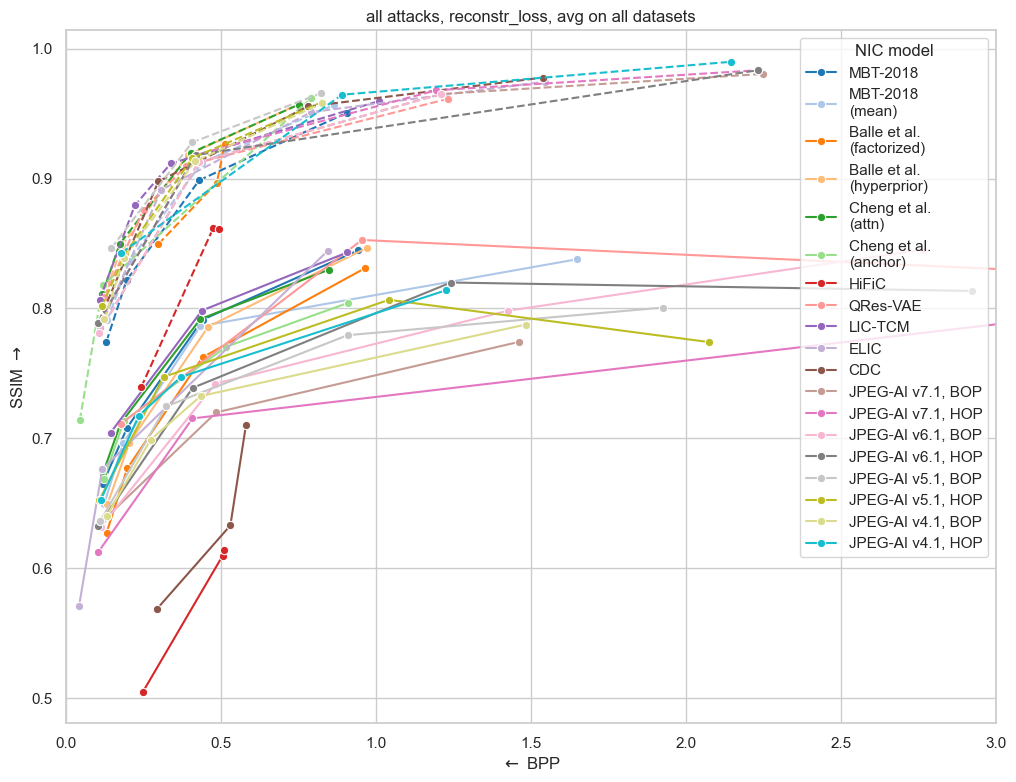

In [ ]:
merged_full_res
x_col = 'bpp_undefended-attacked'
y_col = 'ssim_attacked_rec-attacked'
loss = 'reconstr_loss' # bpp_increase_loss for the attacks targeting bitrate
atk = None
dset = None
preset = 1
plot_data = merged_full_res.copy()
if atk is not None:
    plot_data = plot_data[plot_data.attack_base_name == atk]
plot_data = plot_data[plot_data.loss_name == loss]
if dset is not None:
    plot_data = plot_data[plot_data.test_dataset == dset]

plot_data = plot_data[~plot_data[x_col].isna()]
plot_data = plot_data[~plot_data['bpp_undefended-clear'].isna()]

sns.set(style='whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12, 9))
palette = sns.color_palette('tab20')
plot_data_grpd = plot_data[['codec_name', 'codec_variant', 'codec_variant_num',x_col,y_col]].groupby(['codec_name', 'codec_variant']).agg('mean').reset_index()
plot_data_grpd['codec_name'] = pd.Categorical(plot_data_grpd['codec_name'], codec_order)
plot_data_grpd = plot_data_grpd.sort_values(by='codec_name')
plot_data_grpd['codec_name'] = plot_data_grpd['codec_name'].apply(lambda x: codec_2_name[x])
print(plot_data_grpd.reset_index()['codec_name'].unique())
sns.lineplot(plot_data_grpd, x=x_col, y=y_col, hue='codec_name', ax=ax, marker="o", palette=palette)
x_col = 'bpp_undefended-clear'
y_col = 'ssim_clear_rec-clear'
plot_data_grpd = plot_data[['codec_name', 'codec_variant', 'codec_variant_num',x_col,y_col]].groupby(['codec_name', 'codec_variant']).agg('mean')
plot_data_grpd = plot_data_grpd.sort_values(by='codec_name')
sns.lineplot(plot_data_grpd, x=x_col, y=y_col, hue='codec_name', ax=ax, linestyle='--', legend=False, marker="o", palette=palette)
ax.set_xlim([0,3])
ax.legend(title='NIC model')
ax.set_ylabel('SSIM $\\rightarrow$')
ax.set_xlabel('$\\leftarrow$ BPP')
ax.set_title(f'all attacks, {loss}, avg on all datasets')

#fig.savefig(f'plots/rd_curves_{loss}_all_{preset}.svg')

## Spiderplot (NIC models)

Text(0.5, 1.0, 'all attacks, reconstr_loss, avg on all datasets')

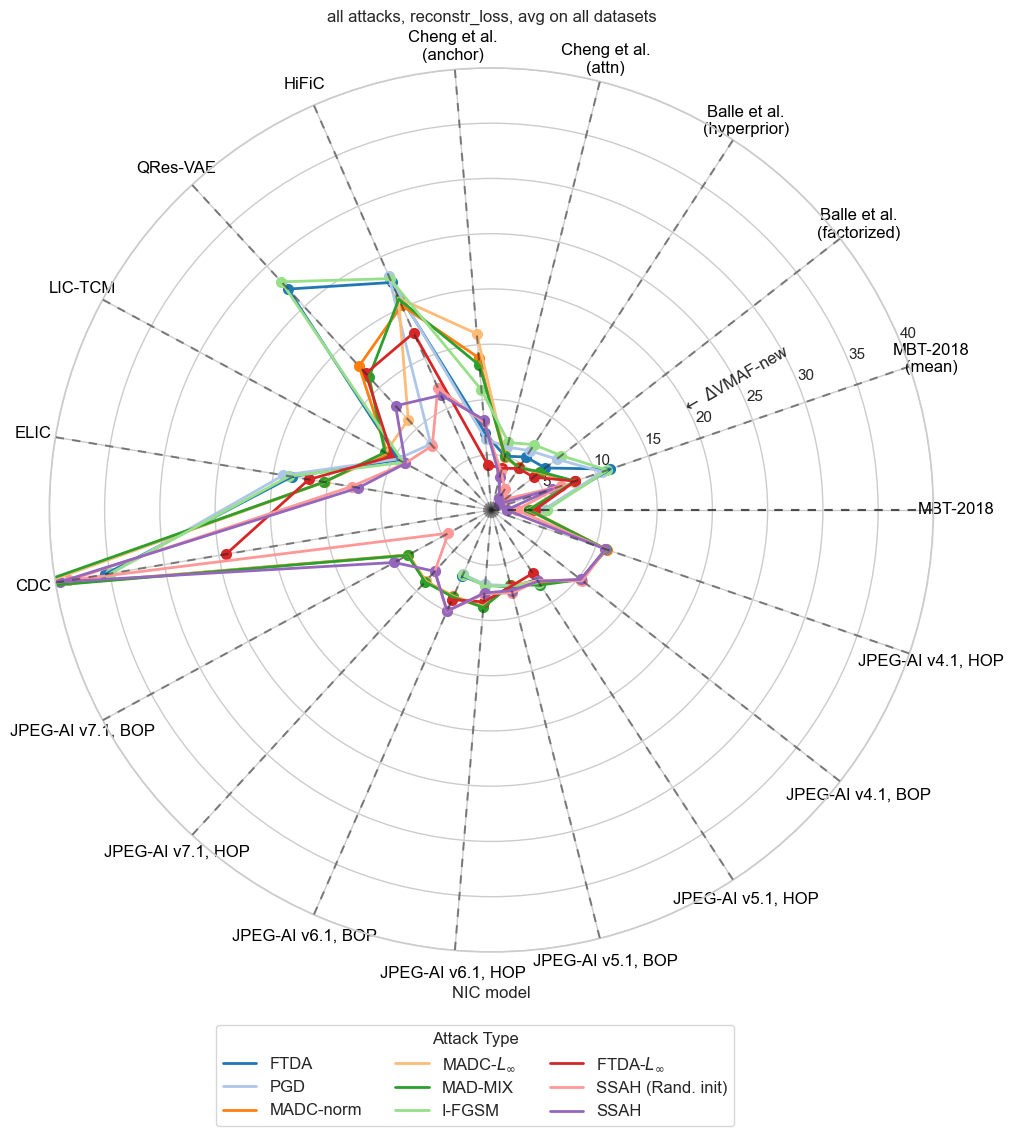

In [28]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

merged_full_res
y_col = 'delta_vmaf_new'
loss = 'reconstr_loss'
preset = 1
GREY12 = "#1f1f1f"

plot_data = merged_full_res.copy()
plot_data = plot_data[plot_data.loss_name == loss]
if dset is not None:
    plot_data = plot_data[plot_data.test_dataset == dset]
plot_data = plot_data[plot_data.attack_base_name != 'madc']


sns.set(style='whitegrid')
fig, ax = plt.subplots(1,1, figsize=(13, 13), subplot_kw=dict(polar=True))
palette = sns.color_palette('tab20')

plot_data_grpd = plot_data[['codec_name', 'codec_variant', 'attack_base_name',y_col]].groupby(['codec_name', 'codec_variant', 'attack_base_name']).agg('mean').reset_index()
plot_data_grpd['codec_name'] = pd.Categorical(plot_data_grpd['codec_name'], codec_order)
plot_data_grpd = plot_data_grpd.sort_values(by='codec_name')
plot_data_grpd['codec_name'] = plot_data_grpd['codec_name'].astype(str)

N = len(codec_order)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

ax.vlines(angles, 0, 41, color=GREY12, ls=(0, (4, 4)), zorder=11, alpha=0.5)

plotted_atks = plot_data_grpd.attack_base_name.unique().tolist()
for i, atk in enumerate(plotted_atks):
    cur_df = plot_data_grpd[plot_data_grpd.attack_base_name == atk][['codec_name', y_col]].groupby('codec_name').agg('mean').reset_index()
    values = []
    for c in codec_order:
        if c in cur_df.codec_name.unique():
            values.append(cur_df[cur_df.codec_name == c][y_col].values[0])
        else:
            values.append(None)
    values += values[:1]
    ax.plot(angles, values, color=palette[i], linewidth=2, linestyle='solid', label=atk_2_name[atk])
    ax.scatter(angles, values, color=palette[i], linewidth=2, linestyle='solid')

ax.text(angles[1]+ 0.16, 25, '$\\leftarrow$ $\\Delta$VMAF-new', rotation=30, 
        ha="center", va="center", size=12, zorder=12)

h, l = ax.get_legend_handles_labels()
plt.xticks(angles[:-1], [codec_2_name[x] for x in codec_order], color='black', size=12)
fig.subplots_adjust(bottom=0.2)
cbaxes = inset_axes( 
    ax,
    width="100%", 
    height="100%", 
    loc="center",
    bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
    bbox_transform=fig.transFigure # Note it uses the figure.
) 
legend = cbaxes.legend(handles=h, labels=l,title="Attack Type", ncol=3, loc='center', fontsize=12)
cbaxes.axis('off')
ax.set_ylim([0,40])
ax.legend(title='Attack')
ax.get_legend().remove()
ax.set_xlabel('NIC model')
ax.set_title(f'all attacks, {loss}, avg on all datasets')
#fig.savefig(f'plots/spider_plot_attacks_{loss}_{preset}_{y_col}.svg')

## Spiderplot (defenses)

Text(0.5, 1.0, 'all attacks, 0 preset, ftda_default_loss_Y, avg on all datasets')

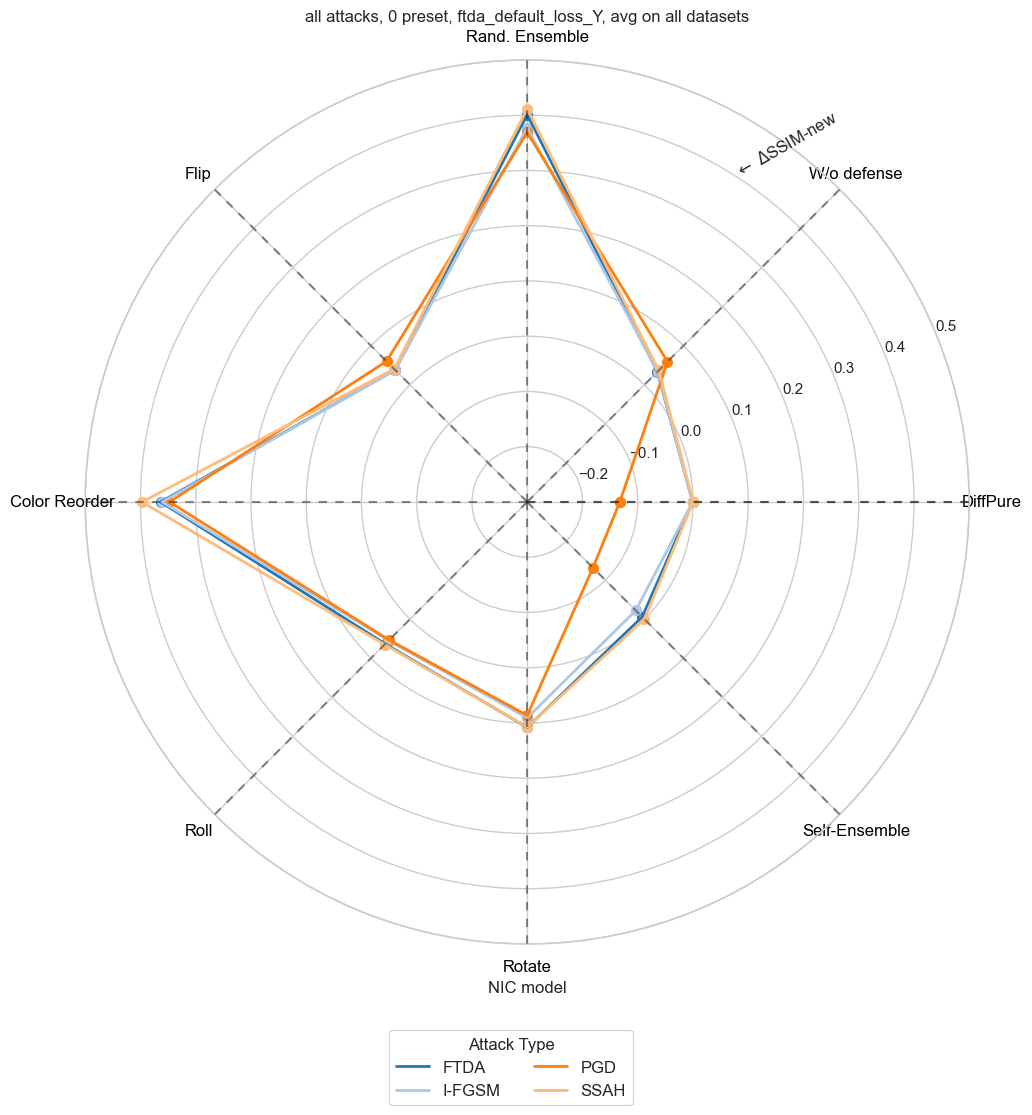

In [ ]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
y_col = 'delta_ssim_new'
loss = 'ftda_default_loss_Y'
preset = 0
GREY12 = "#1f1f1f"

plot_data = defense_res.copy()
plot_data = plot_data[plot_data.loss_name == loss]
plot_data[y_col] = plot_data[y_col].replace([np.inf, -np.inf], np.nan)
plot_data = plot_data[~plot_data[y_col].isna()]

sns.set(style='whitegrid')
fig, ax = plt.subplots(1,1, figsize=(13, 13), subplot_kw=dict(polar=True))
palette = sns.color_palette('tab20')

plot_data_grpd = plot_data[['codec_name', 'codec_variant', 'attack_base_name', 'defense_name', y_col]]\
    .groupby(['codec_name', 'codec_variant', 'attack_base_name', 'defense_name',]).agg('mean')\
    .groupby(['attack_base_name', 'defense_name']).agg('mean')\
    .reset_index()

defense_order = plot_data_grpd['defense_name'].unique().tolist()
N = len(defense_order)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
ax.vlines(angles, -0.3, 0.5, color=GREY12, ls=(0, (4, 4)), zorder=11, alpha=0.5)

plotted_atks = plot_data_grpd.attack_base_name.unique().tolist()
for i, atk in enumerate(plotted_atks):
    cur_df = plot_data_grpd[plot_data_grpd.attack_base_name == atk][['defense_name', y_col]].groupby('defense_name').agg('mean').reset_index()

    values = []
    for c in defense_order:
        if c in cur_df.defense_name.unique():
            values.append(cur_df[cur_df.defense_name == c][y_col].values[0])
        else:
            values.append(None)
    values += values[:1]
    ax.plot(angles, values, color=palette[i], linewidth=2, linestyle='solid', label=atk_2_name[atk])
    ax.scatter(angles, values, color=palette[i], linewidth=2, linestyle='solid')

ax.text(angles[1]+ 0.16, 0.5, '$\\leftarrow$ $\\Delta$SSIM-new', rotation=30, 
        ha="center", va="center", size=12, zorder=12)

h, l = ax.get_legend_handles_labels()
plt.xticks(angles[:-1], [defense_2_name[x] for x in defense_order], color='black', size=12)
fig.subplots_adjust(bottom=0.2)
cbaxes = inset_axes( 
    ax,
    width="100%", 
    height="100%", 
    loc="center",
    bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
    bbox_transform=fig.transFigure 
) 
legend = cbaxes.legend(handles=h, labels=l,title="Attack Type", ncol=2, loc='center', fontsize=12)
cbaxes.axis('off')
ax.set_ylim([-0.3,0.5])
ax.legend(title='Attack')
ax.get_legend().remove()
ax.set_xlabel('NIC model')
ax.set_title(f'all attacks, {preset} preset, {loss}, avg on all datasets')
#fig.savefig(f'plots/spider_plot_defenses_{loss}_{y_col}.svg')